In [1]:
import numpy as np
import pandas as pd
import pickle
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, random_split
import os
from sklearn.metrics import confusion_matrix,f1_score
import matplotlib.pyplot as plt
import seaborn as sn


Dense Layer

In [ ]:
class Dense:
    def __init__(self, input_dim, output_dim):
        # Xavier initialization, input_dim+output_dim/input_dim
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2 / (input_dim+output_dim))
        self.bias = np.zeros((1, output_dim))
        
    def forward(self, X):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        self.input = X
        # Wx+b
        self.output = np.dot(X, self.weights) + self.bias
        return self.output
    
    def backward(self, dL_doutput):
        # Gradients
        dL_dinput = np.dot(dL_doutput, self.weights.T)
        dL_dweights = np.dot(self.input.T, dL_doutput)
        dL_dbias = np.sum(dL_doutput, axis=0, keepdims=True)
        
        # Update weights and biases
        self.grads = {
            'weights': dL_dweights,
            'bias': dL_dbias
        }
        return dL_dinput

Normalization

In [ ]:
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
        self.input_dim=input_dim
        self.epsilon = epsilon
        self.momentum = momentum
        # scale parameter
        self.gamma = np.ones((1, self.input_dim))
        # shift parameter
        self.beta = np.zeros((1, self.input_dim))
        self.moving_mean = np.zeros((1, self.input_dim))
        self.moving_var = np.ones((1, self.input_dim))

    def forward(self, X, training=True):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        if training:
            # page 296, something about len(X.shape)
            self.mean = np.mean(X, axis=0, keepdims=True)
            self.var = np.var(X, axis=0, keepdims=True)
            self.X_centered = X - self.mean
            self.std = np.sqrt(self.var + self.epsilon)
            self.X_norm=self.X_centered/self.std

            # Update running statistics
            self.moving_mean = self.momentum * self.moving_mean + (1 - self.momentum) * self.mean
            self.moving_var = self.momentum * self.moving_var + (1 - self.momentum) * self.var
        else:
            self.X_norm = (X - self.moving_mean) / np.sqrt(self.moving_var + self.epsilon)
        
        return self.gamma * self.X_norm + self.beta
    # confused about the backward propagation
    def backward(self, dL_doutput):
        m = dL_doutput.shape[0]
        dL_dgamma = np.sum(dL_doutput * self.X_norm, axis=0, keepdims=True)
        dL_dbeta = np.sum(dL_doutput, axis=0, keepdims=True)
        dL_dX_norm = dL_doutput * self.gamma
        dL_dvar = np.sum(dL_dX_norm * self.X_centered * -0.5 / (self.std ** 3), axis=0, keepdims=True)
        dL_dmean = np.sum(dL_dX_norm * -1 / self.std, axis=0, keepdims=True) + dL_dvar * np.mean(-2 * self.X_centered, axis=0, keepdims=True)
        
        dL_dinput = dL_dX_norm / self.std + dL_dvar * 2 * self.X_centered / m + dL_dmean / m
        
        self.grads = {
            'gamma': dL_dgamma,
            'beta': dL_dbeta
        }
        
        return dL_dinput


Activation

In [4]:
class ReLU:
    def forward(self, X):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        self.output = np.maximum(0, X)
        return self.output
    
    def backward(self, dL_doutput):
        return dL_doutput * (self.output > 0)


Regularization

In [ ]:
# Apply after activation function, page 177
class Dropout:

    def __init__(self, dropout):
        self.dropout = dropout


    def forward(self, X, training=True):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        if training:
            assert 0 <= self.dropout <= 1
            # In this case, all elements are dropped out
            if self.dropout == 1:
                return np.zeros_like(X)
            # In this case, all elements are kept
            if self.dropout == 0:
                return X
            self.mask = np.random.uniform(0, 1, X.shape) > self.dropout
            # self.mask = np.random.binomial(1, 1 - self.dropout, size=X.shape)

            return X * self.mask.astype(np.float32) / (1.0 - self.dropout)

        return X

    # confused about the back propagation
    def backward(self, dL_doutput):
        return dL_doutput * self.mask / (1.0 - self.dropout)

Optimization

In [6]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # momentum
        self.v = {}
        # second momentum
        self.s = {}
        # time step counter
        self.t = 0
        
    def update(self, params, grads):
        self.t += 1
        for param_name in params:
            if param_name not in self.v.keys():
                self.v[param_name] = np.zeros_like(grads[param_name])
                self.s[param_name] = np.zeros_like(grads[param_name])
            
            # Momentum estimates
            self.v[param_name] = self.beta1 * self.v[param_name] + (1 - self.beta1) * grads[param_name]
            self.s[param_name] = self.beta2 * self.s[param_name] + (1 - self.beta2) * np.square(grads[param_name])
            
            v_bias_corr = self.v[param_name] / (1 - self.beta1 ** self.t)
            s_bias_corr = self.s[param_name] / (1 - self.beta2 ** self.t)
            
            params[param_name] -= self.learning_rate * v_bias_corr / (np.sqrt(s_bias_corr) + self.epsilon)


Regression

In [7]:
class Softmax:
    def forward(self, X):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output
    
    def backward(self, dL_doutput):
        # In multi-class classification, the gradient of cross-entropy with softmax simplifies the backward pass.
        return dL_doutput


Feed-Forward Neural Network implementation

In [8]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X, training=True):

        # print('start')
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        for layer in self.layers:
            if isinstance(layer, Dropout):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, dL_doutput):
        for layer in reversed(self.layers):
            dL_doutput = layer.backward(dL_doutput)

    def get_params_and_grads(self):
        params_and_grads = {}
        for layer in self.layers:
            if isinstance(layer, Dense) or isinstance(layer, BatchNormalization):
                if isinstance(layer, Dense):
                    params_and_grads.update({
                        f'{layer.__class__.__name__}_weights': layer.weights,
                        f'{layer.__class__.__name__}_bias': layer.bias,
                        f'{layer.__class__.__name__}_grads_weights': layer.grads['weights'],
                        f'{layer.__class__.__name__}_grads_bias': layer.grads['bias']
                    })
                if isinstance(layer, BatchNormalization):
                    params_and_grads.update({
                        f'{layer.__class__.__name__}_gamma': layer.gamma,
                        f'{layer.__class__.__name__}_beta': layer.beta,
                        f'{layer.__class__.__name__}_grads_gamma': layer.grads['gamma'],
                        f'{layer.__class__.__name__}_grads_beta': layer.grads['beta']
                    })
        return params_and_grads

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size,learning_rate,index=0):
        optimizer = AdamOptimizer(learning_rate)
        train_loss = []
        validation_loss = []
        training_acc = []
        validation_acc = []
        val_f1_scores = []
        for epoch in range(epochs):
            correct_train = 0
            correct_val = 0
            training_loss = 0.0
            val_loss = 0.0
            # Divide into batches
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                # Forward pass
                predictions = self.forward(X_batch, training=True)
                loss = -np.mean(np.sum(y_batch * np.log(predictions + 1e-8), axis=1))  # Cross-entropy loss
                # calculate loss
                training_loss += loss * len(X_batch)
                # calculate accuracy
                correct_train += np.sum(np.argmax(predictions, axis=1) == np.argmax(y_batch, axis=1))
                # Backward pass
                dL_doutput = predictions - y_batch  # Gradient of cross-entropy
                self.backward(dL_doutput)
                
                # Get params and gradients, update using Adam optimizer
                params_and_grads = self.get_params_and_grads()
                optimizer.update({k: params_and_grads[k] for k in params_and_grads if 'grads' not in k},
                                 {k.split('grads_')[0]+k.split('grads_')[1]: params_and_grads[k] for k in params_and_grads if 'grads' in k})
                # if epoch==epochs-1 and i+batch_size>=len(X_train):
                #     self.save_model(filepath)
            training_loss /= len(X_train)
            train_loss.append(training_loss)
            training_acc.append(correct_train / len(y_train))
            # calculate validation loss
            val_predictions = self.predict(X_val)
            val_loss = -np.mean(np.sum(y_val * np.log(val_predictions + 1e-8), axis=1))
            validation_loss.append(val_loss)

            # calculate validation accuracy
            correct_val += np.sum(np.argmax(val_predictions, axis=1) == np.argmax(y_val, axis=1))
            acc = correct_val / len(y_val)
            validation_acc.append(acc)
            # calculate f1
            f1 = f1_score(np.argmax(y_val, axis=1), np.argmax(val_predictions, axis=1), average='macro')
            val_f1_scores.append(f1)
            # print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}')
            if i % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {training_loss}, Val Loss: {val_loss}")
                print(f"Train Accuracy: {correct_train / len(y_train) * 100}, Val Accuracy: {correct_val / len(y_val) * 100}", f"F1 Score: {f1 * 100}")
        # plot graphs
        
        # show both training and validation loss in the same graph wrt epoch
        if index!=0:
            plt.title(F"Learning rate={learning_rate},model={index}")
        plt.plot(train_loss, label='Train Loss')
        plt.plot(validation_loss, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        if index!=0:
            plt.title(F"Learning rate={learning_rate},model={index}")
        plt.plot(training_acc, label='Train Accuracy')
        plt.plot(validation_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        if index!=0:
            plt.title(F"Learning rate={learning_rate},model={index}")
        plt.plot(val_f1_scores, label='Val F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.show()

        # confusion matrix
        val_predictions = self.predict(X_val)
        cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(val_predictions, axis=1))
        df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                    columns = [i for i in "0123456789"])
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        plt.show()
        
    def predict(self, X):
        return self.forward(X, training=False)
    
    def evaluate(self,X_test,y_test):
        prediction = self.predict(X_test)
        cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1))
        # y_pred=[[1 if prob == max(row) else 0 for prob in row] for row in prediction]
        # y_pred=np.array(y_pred)
        # accuracy = np.mean(y_pred == y_test)
        correct_predictions = np.trace(cm)
        total_instances = np.sum(cm)
        accuracy = correct_predictions / len(y_test)
        loss = -np.mean(np.sum(y_test * np.log(prediction + 1e-8), axis=1))  # Cross-entropy loss
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Loss: {loss}")
        # y_test=[[j if k == 1 else 0 for j,k in enumerate(i)] for i in y_test]
        # y_test=[max(i) for i in y_test]
        # y_pred=[[j if k == 1 else 0 for j,k in enumerate(i)] for i in y_pred]
        # y_pred=[max(i) for i in y_pred]
        TP = []
        FP = []
        FN = []
        TN = []
        num_classes = cm.shape[0]
        for i in range(num_classes):
            TP_i = cm[i, i]
            FP_i = cm[:, i].sum() - TP_i
            FN_i = cm[i, :].sum() - TP_i
            TN_i = cm.sum() - (TP_i + FP_i + FN_i)
            
            TP.append(TP_i)
            FP.append(FP_i)
            FN.append(FN_i)
            TN.append(TN_i)

        specificities = []
        precisions = []
        recalls = []
        f1_scores = []

        for i in range(len(TP)):
            specificity = TN[i] / (TN[i] + FP[i]) if (TN[i] + FP[i]) > 0 else 0
            precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0
            recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            specificities.append(specificity)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

        avg_specificity = sum(specificities) / len(specificities)
        avg_precision = sum(precisions) / len(precisions)
        avg_recall = sum(recalls) / len(recalls)
        avg_f1_score = sum(f1_scores) / len(f1_scores)

        print("Average Specificity:", avg_specificity)
        print("Average Precision:", avg_precision)
        print("Average Recall:", avg_recall)
        print("Average F1 Score:", avg_f1_score)
        # print(y_test[:10])
        # print(y_pred[:10])
        # for i,row in enumerate(y_test):
        #     for j,element in enumerate(row):
        #         # print(element,y_pred[j])
        #         if element==1 and y_pred[i][j]==1:
        #             tp+=1
        #         elif element==1 and y_pred[i][j]==0:
        #             fn+=1
        # for i,row in enumerate(y_pred):
        #     for j,element in enumerate(row):
        #         # print(element,y_pred[j])
        #         if element==0:
        #             continue
        #         elif element==1 and y_test[i][j]==0:
        #             fp+=1
        # tn=len(y_test)-fp
        # print('tn\tfp\tfn\ttp')
        # print(f'{tn}\t{fp}\t{fn}\t{tp}')
        # # print(y_test[:10])
        # # print(y_pred[:10])
        # specificity = tn / (tn + fp)
        # precision = tp/(tp+fp)
        # f1 = 2*specificity*precision/(specificity+precision)
        # # print(f1)
        # print("F1 Score: ", f1)

        return accuracy,loss,avg_f1_score

    def save_model(self, filepath):
        params = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Dense):
                params[f"layer_{i}_weights"] = layer.weights
                params[f"layer_{i}_bias"] = layer.bias
            if isinstance(layer, BatchNormalization):
                params[f"layer_{i}_gamma"] = layer.gamma
                params[f"layer_{i}_beta"] = layer.beta
        with open(filepath, 'wb') as f:
            pickle.dump(params, f)

    def load_model(self, filepath):
        with open(filepath, 'rb') as f:
            params = pickle.load(f)

        for i, layer in enumerate(self.layers):
            if isinstance(layer, Dense):
                layer.weights = params[f"layer_{i}_weights"]
                layer.bias = params[f"layer_{i}_bias"]
            if isinstance(layer, BatchNormalization):
                layer.gamma = params[f"layer_{i}_gamma"]
                layer.beta = params[f"layer_{i}_beta"]


Data loading

In [9]:
def load_data():
    transform=transforms.ToTensor()
    train_dataset=datasets.FashionMNIST(root='./data',train=True,transform=transform,download=True)
    test_dataset=datasets.FashionMNIST(root='./data',train=False,transform=transform,download=True)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    X_train, y_train = next(iter(train_loader))
    X_train= X_train / 255.0
    X_train = X_train.reshape(-1, 28*28).numpy()  # Flatten the images
    y_train=np.eye(10)[y_train]

    X_val, y_val = next(iter(val_loader))
    X_val= X_val / 255.0
    X_val = X_val.reshape(-1, 28*28).numpy()  # Flatten the images
    y_val=np.eye(10)[y_val]

    X_test, y_test = next(iter(test_loader))
    X_test= X_test / 255.0
    X_test = X_test.reshape(-1, 28*28).numpy()
    y_test=np.eye(10)[y_test]

    # print(y_val[:10])
    # y_val=[[j if k == 1 else 0 for j,k in enumerate(i)] for i in y_val]
    # y_val=[max(i) for i in y_val]
    # print(y_val[:10])
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

Data cleaning

Building the architecture

In [10]:
# Define network architecture
# network = NeuralNetwork([
#     Layer(input_dim=28*28, output_dim=128),
#     BatchNormalization(input_dim=128),
#     ReLU(),
#     Dropout(dropout=0.2),
#     Layer(input_dim=128, output_dim=10),
#     Softmax()
# ])

# here Layer(784, 128) means input layer has 784 neurons and hidden layer has 128 neurons
# Layer(128, 10) that hidden layer with 128 layers plus output layer with 10 neurons
X_train, y_train, X_val, y_val, X_test, y_test=load_data()
folder_path = './pickle/'
filename = 'weights.pkl'
os.makedirs(folder_path, exist_ok=True)
filepath = os.path.join(folder_path, filename)
# network.train(X_train,y_train,X_val,y_val,10,64,0.005)
# network.save_model(filepath)

X_train shape: (48000, 784)
y_train shape: (48000, 10)
X_val shape: (12000, 784)
y_val shape: (12000, 10)
X_test shape: (10000, 784)
y_test shape: (10000, 10)


Validation block

In [11]:
# network.evaluate(X_val,y_val)

In [12]:
# # The hyperparameter we'll change is the number of hidden layers, ranging from 1 to 5
# best_accuracy = 0
# best_model = None
# layers=[]
# layers.append(Layer(input_dim=28*28, output_dim=256))
# for i, layer_size in enumerate(range(1,6,1)):
#     print ('{}: Testing neural network MLP classifier with {} hidden layers with constant number of layers'.format(i+1, layer_size))
#     if layer_size!=1:
#         layers.pop()
#         layers.pop()
#         layers.append(Layer(256,256))
#     layers.append(BatchNormalization(256))
#     layers.append(ReLU())
#     layers.append(Dropout(0.2))
#     layers.append(Layer(256,10))
#     layers.append(Softmax())
#     model = NeuralNetwork(layers)

#     # Train
#     model.train(X_train, y_train,10,64,filepath)

#     current_accuracy,current_loss,current_f1 = model.evaluate(X_val, y_val)

#     if best_accuracy < current_accuracy:
#         best_model=model
#         best_accuracy = current_accuracy

#     del (model)


In [13]:
# # The hyperparameter we'll change is the number of neurons and hidden layers, ranging from 1 to 5 for hidden layers and n_neurons for neurons
# best_accuracy = 0
# best_model = None
# n_neurons=[784,512,256,128,64,32,16,10]
# layers=[]
# layers.append(Layer(input_dim=n_neurons[0], output_dim=n_neurons[1]))
# for i, layer_size in enumerate(range(1,len(n_neurons)-1,1)):
#     print ('{}: Testing neural network MLP classifier with {} hidden layers and variable number of neurons at each layer'.format(i+1, layer_size))
#     if layer_size!=1:
#         layers.pop()
#         layers.pop()
#         layers.append(Layer(n_neurons[layer_size-1],n_neurons[layer_size]))
#     layers.append(BatchNormalization(n_neurons[layer_size]))
#     layers.append(ReLU())
#     layers.append(Dropout(0.2))
#     layers.append(Layer(n_neurons[layer_size],n_neurons[-1]))
#     layers.append(Softmax())
#     model = NeuralNetwork(layers)

#     # Train
#     model.train(X_train, y_train,10,64,filepath)

#     current_accuracy,current_loss,current_f1 = model.evaluate(X_val, y_val)

#     if best_accuracy < current_accuracy:
#         best_model=model
#         best_accuracy = current_accuracy

#     del (model)


In [14]:
# # The hyperparameter we'll change is the number of neurons in the hidden layer, ranging from n_neurons[0] to n_neurons[-1]
# best_model=None
# best_f1=0.0
# # n_neurons=[784,512,256,128,64,32,16,10]
# n_neurons=[784,512,10]
# # learning_rates = [5e-3, 1e-3, 5e-4, 8e-3]
# learning_rates = [5e-3]
# for learning_rate in learning_rates:
#     for i, layer_size in enumerate(range(1,len(n_neurons)-1,1)):
#         print ('{}: Testing neural network MLP classifier with {} neurons in hidden layer'.format(i+1, n_neurons[layer_size]))
#         layers=[]
#         layers.append(Dense(input_dim=n_neurons[0], output_dim=n_neurons[layer_size]))
#         layers.append(BatchNormalization(n_neurons[layer_size]))
#         layers.append(ReLU())
#         layers.append(Dropout(0.2))
#         layers.append(Dense(n_neurons[layer_size],n_neurons[-1]))
#         layers.append(Softmax())
#         model = NeuralNetwork(layers)

#         # Train
#         model.train(X_train, y_train,X_val,y_val,10,64,learning_rate)

#         current_accuracy,current_loss,current_f1 = model.evaluate(X_val, y_val)
        
#         if current_f1>best_f1:
#             best_f1=current_f1
#             best_model=model

# best_model.save_model(filepath)


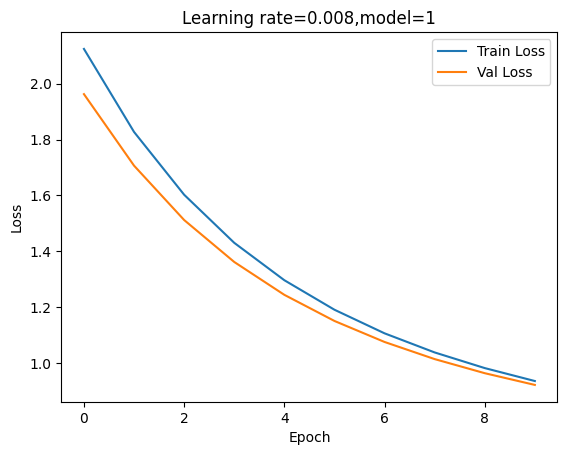

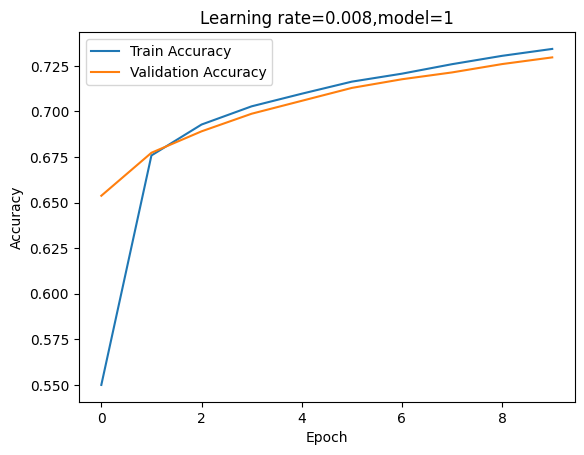

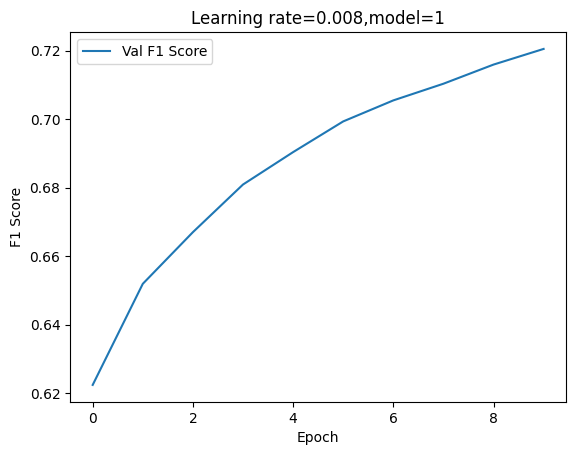

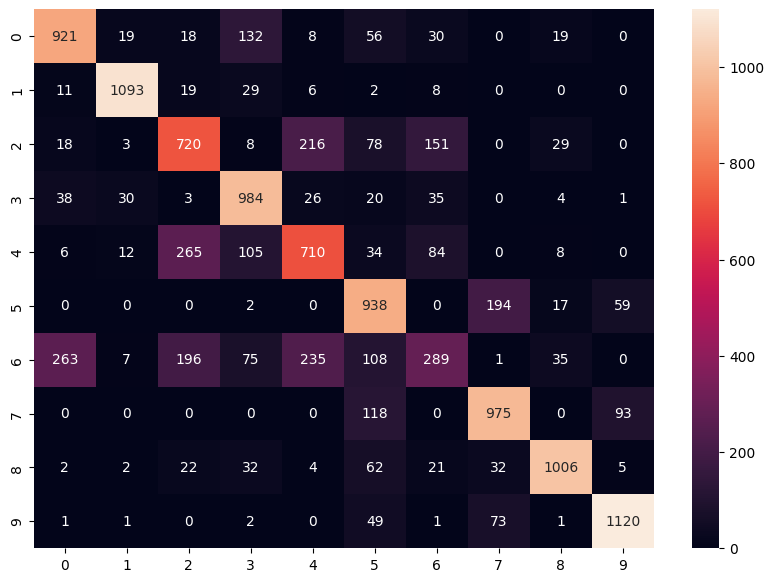

Accuracy: 72.97%
Loss: 0.921817815809837
Average Specificity: 0.9699540963763187
Average Precision: 0.7202017431285558
Average Recall: 0.7313132186930242
Average F1 Score: 0.7205432577299148


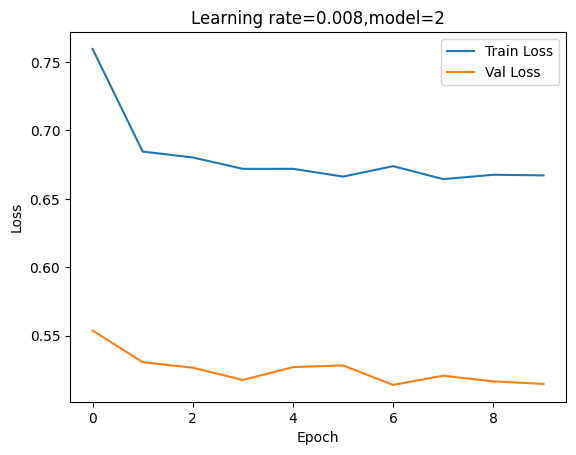

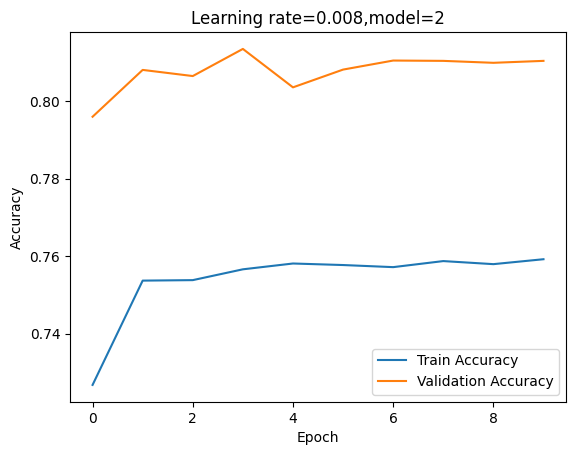

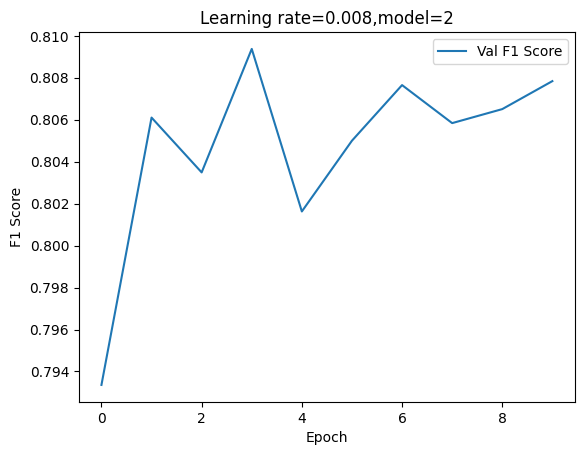

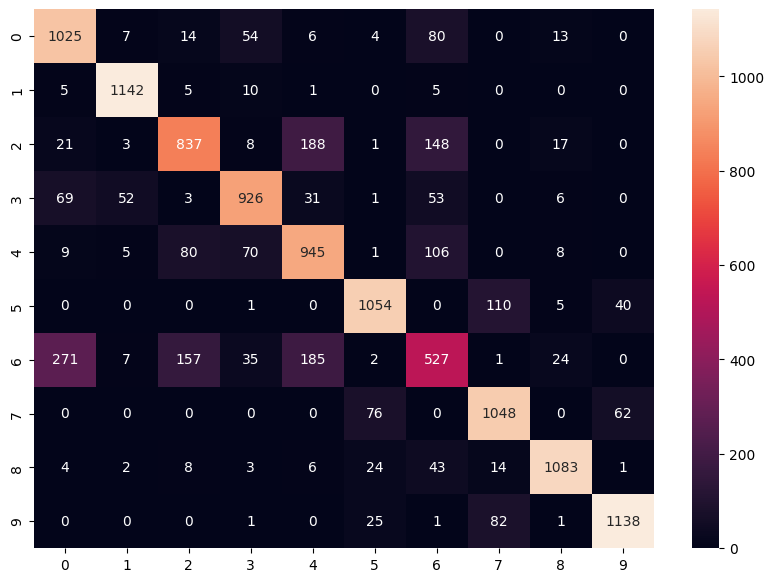

Accuracy: 81.04%
Loss: 0.5146143126493828
Average Specificity: 0.9789260368981033
Average Precision: 0.8077941687481299
Average Recall: 0.8111876037482725
Average F1 Score: 0.8078400078628466


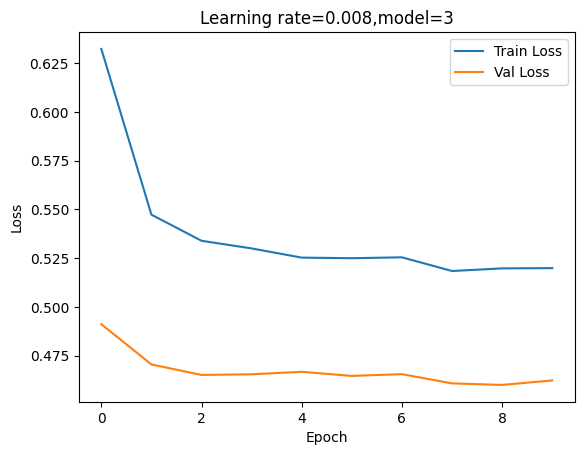

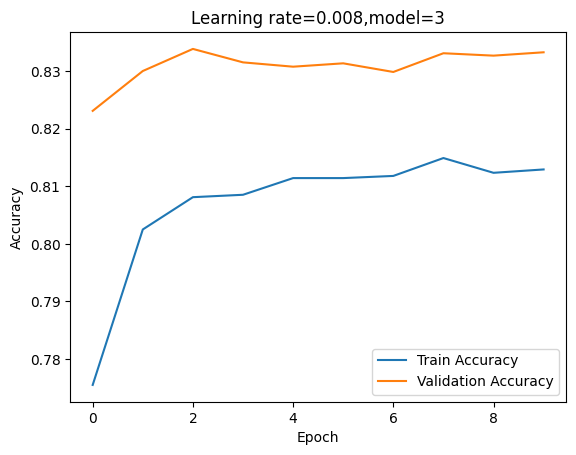

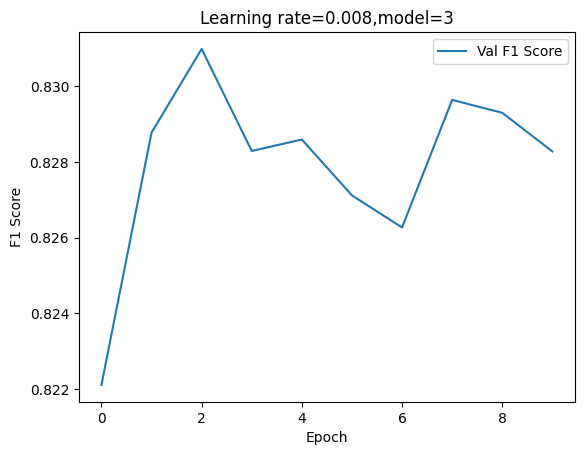

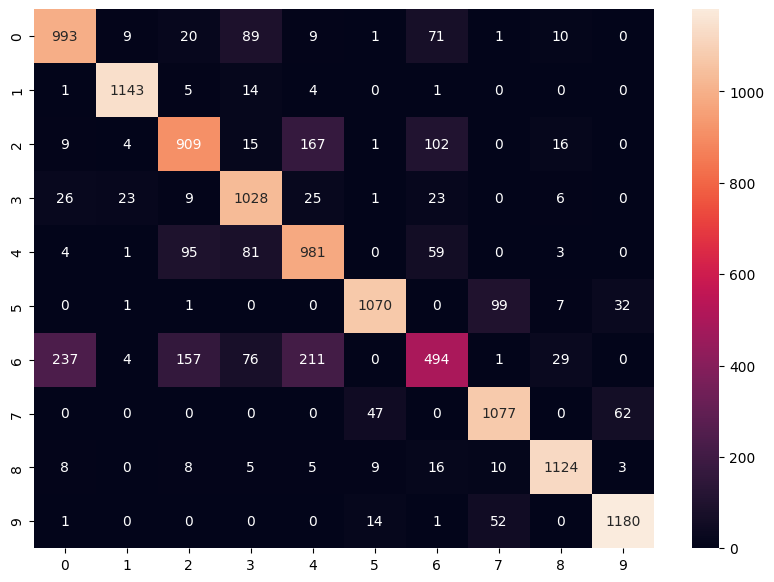

Accuracy: 83.33%
Loss: 0.4622741641986075
Average Specificity: 0.9814681495526522
Average Precision: 0.8294951230289664
Average Recall: 0.8342356119870304
Average F1 Score: 0.8282790818781944


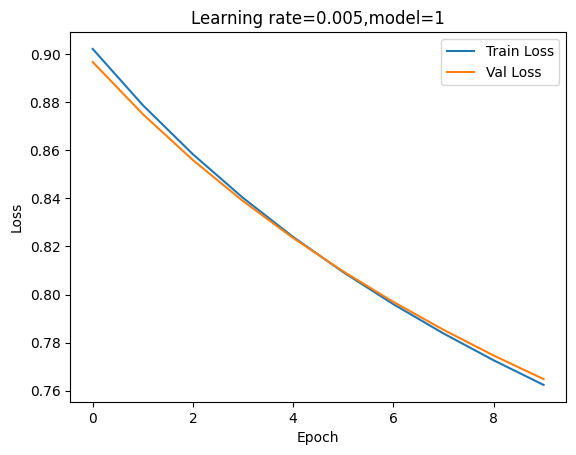

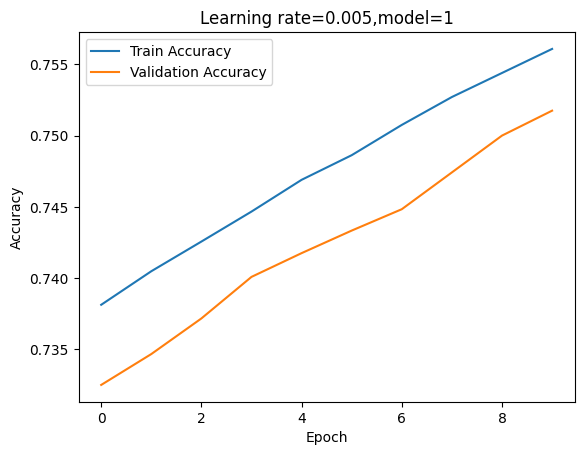

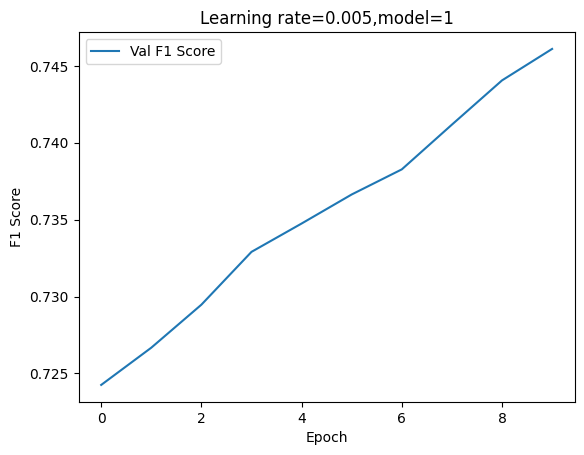

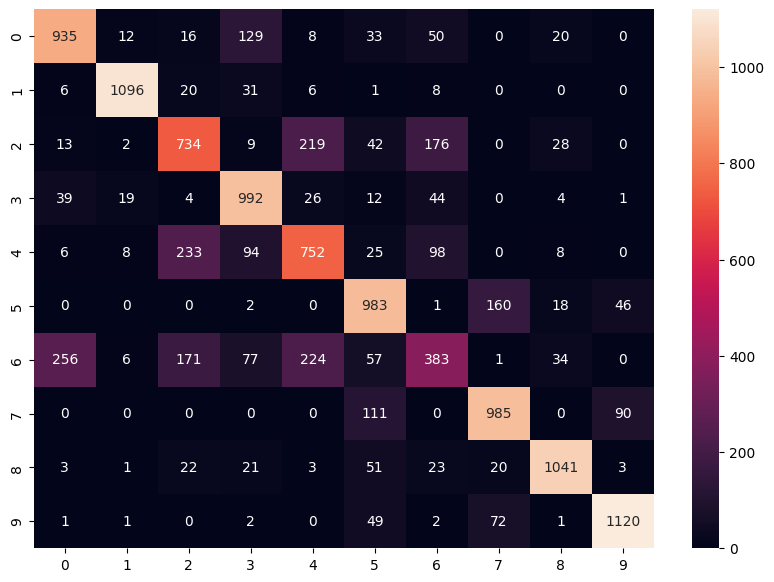

Accuracy: 75.17%
Loss: 0.7648331791879719
Average Specificity: 0.9724083381353814
Average Precision: 0.7445159778767019
Average Recall: 0.7532943904746847
Average F1 Score: 0.7460989634805271


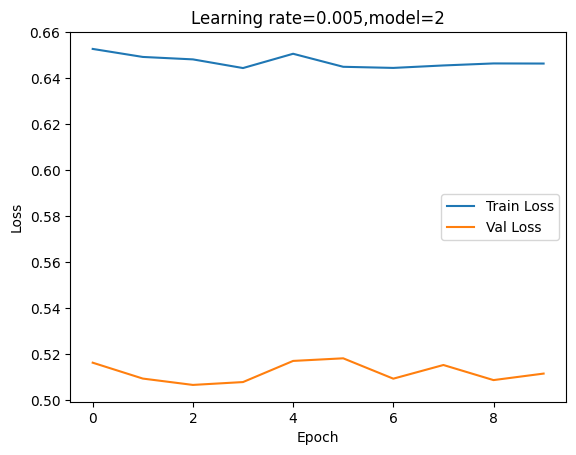

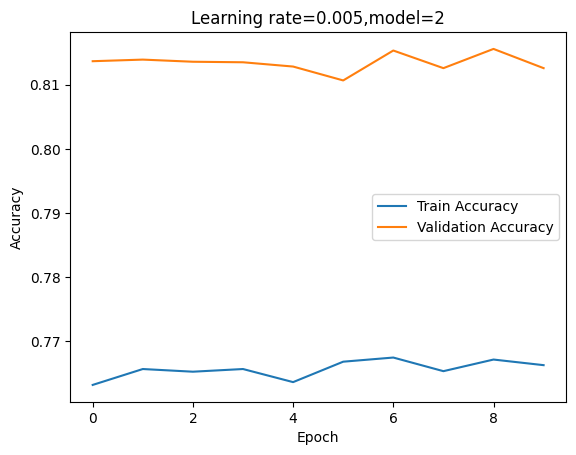

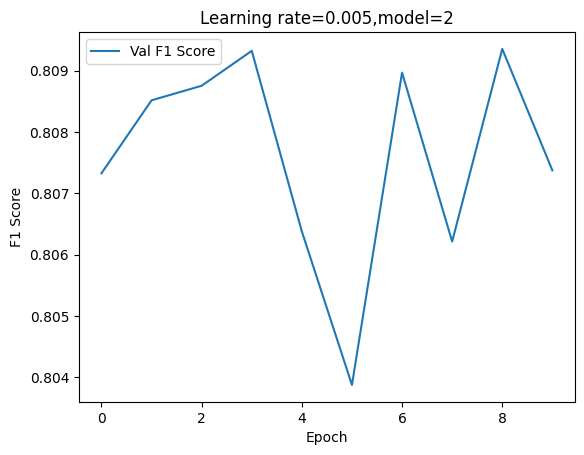

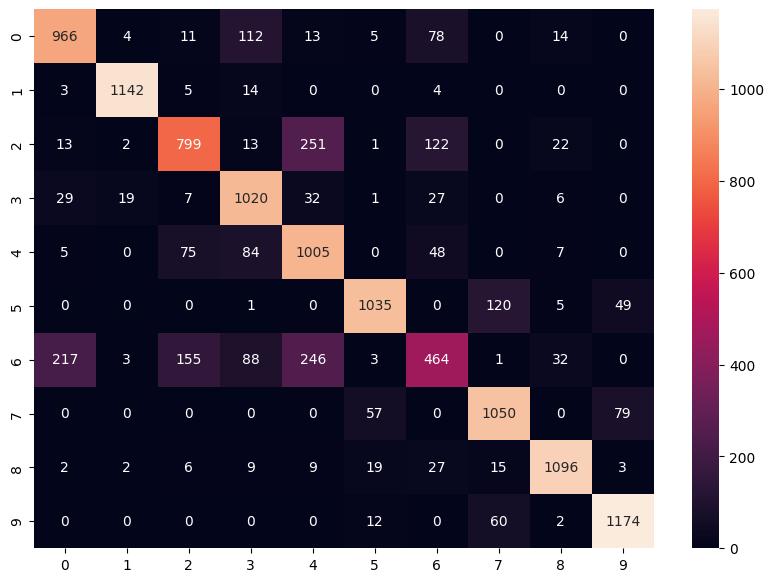

Accuracy: 81.26%
Loss: 0.5116456613321555
Average Specificity: 0.9791703574008656
Average Precision: 0.810239127805686
Average Recall: 0.81368279209954
Average F1 Score: 0.8073740760263254


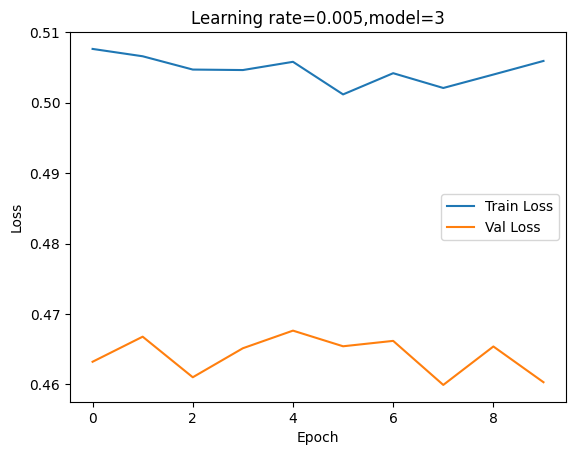

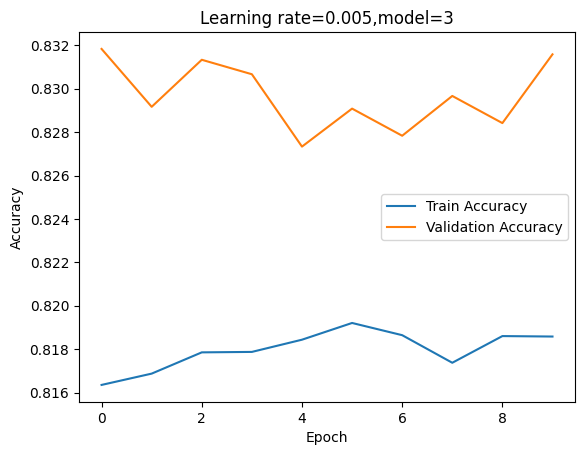

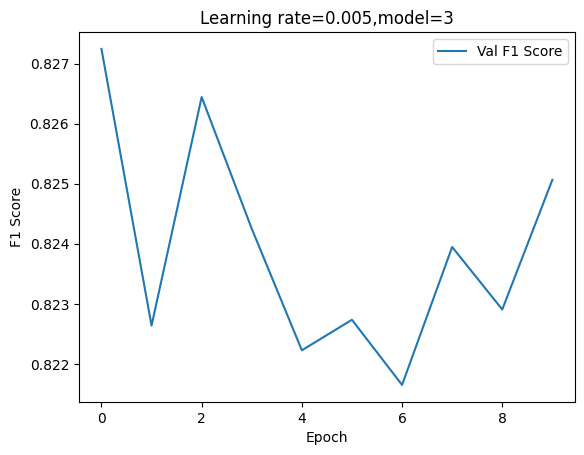

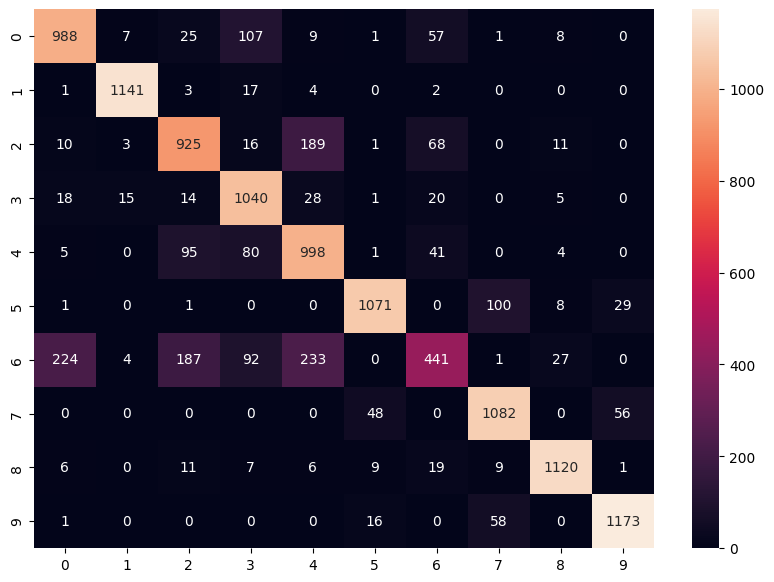

Accuracy: 83.16%
Loss: 0.4603054584580076
Average Specificity: 0.9812837419555148
Average Precision: 0.8299033619873091
Average Recall: 0.8326204515706817
Average F1 Score: 0.8250641359631132


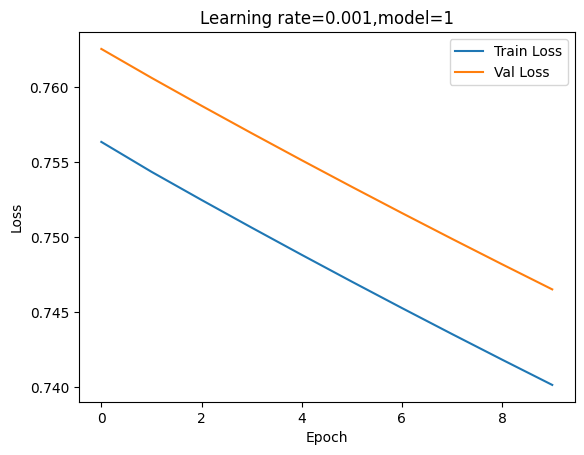

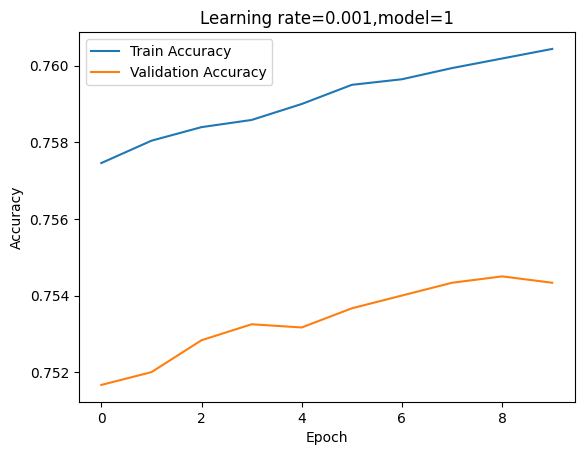

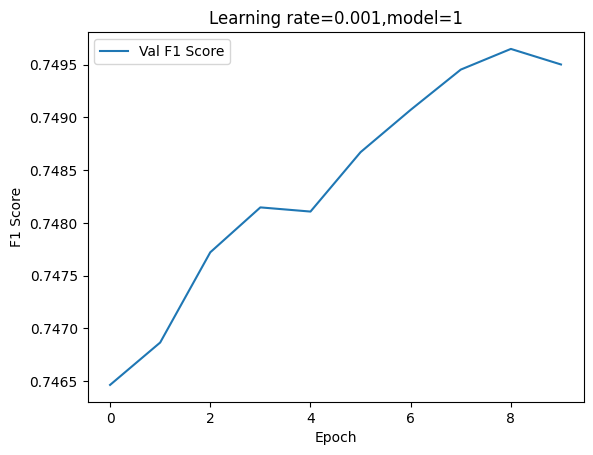

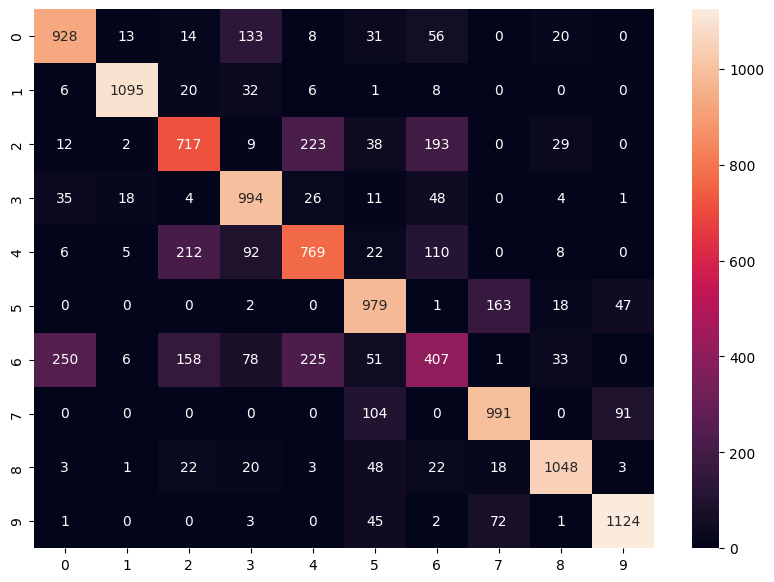

Accuracy: 75.43%
Loss: 0.7465086643862572
Average Specificity: 0.9726959968725138
Average Precision: 0.7476109919021721
Average Recall: 0.7558712183486085
Average F1 Score: 0.7495009928655655


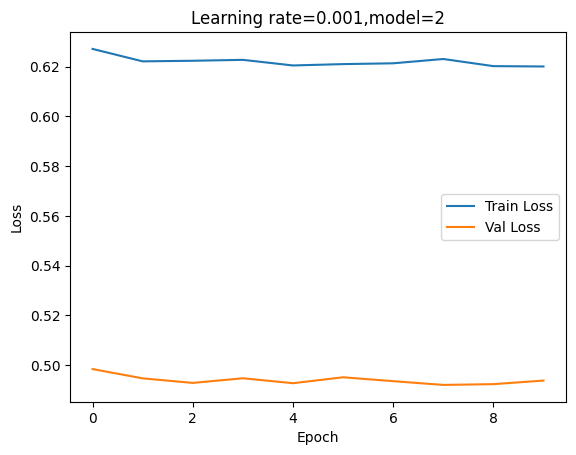

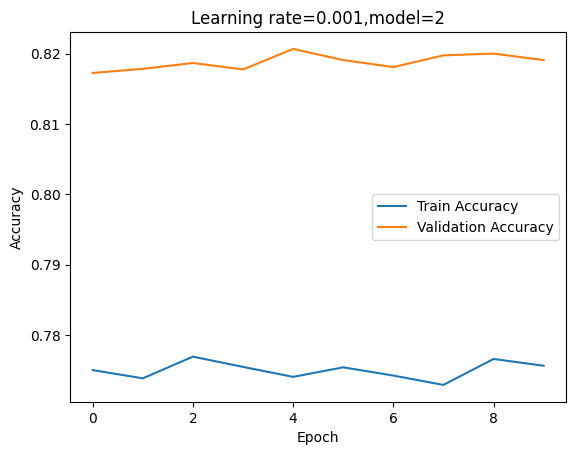

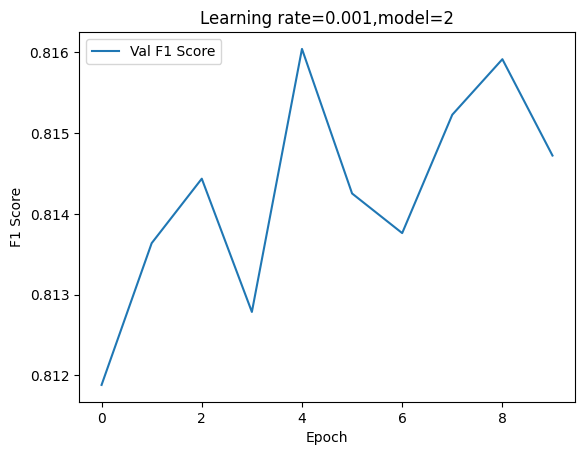

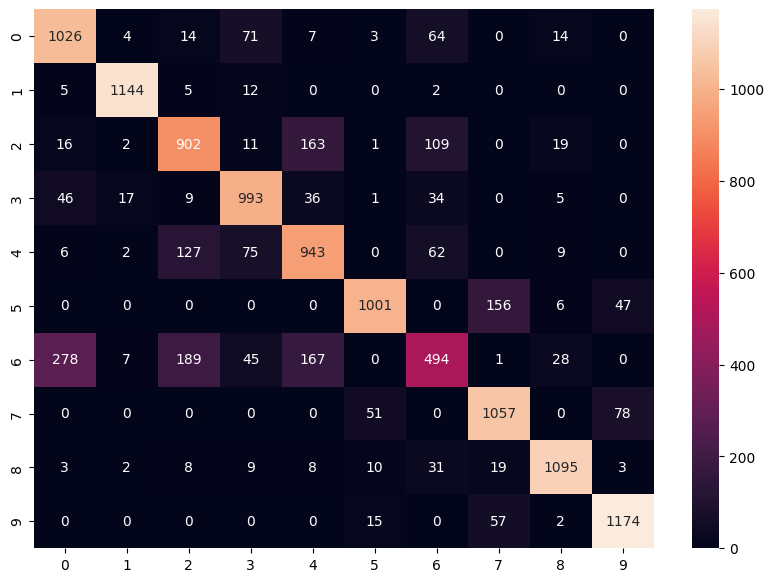

Accuracy: 81.91%
Loss: 0.4937592031780928
Average Specificity: 0.9798899010518568
Average Precision: 0.8159114315623999
Average Recall: 0.8200092810508497
Average F1 Score: 0.8147222059331638


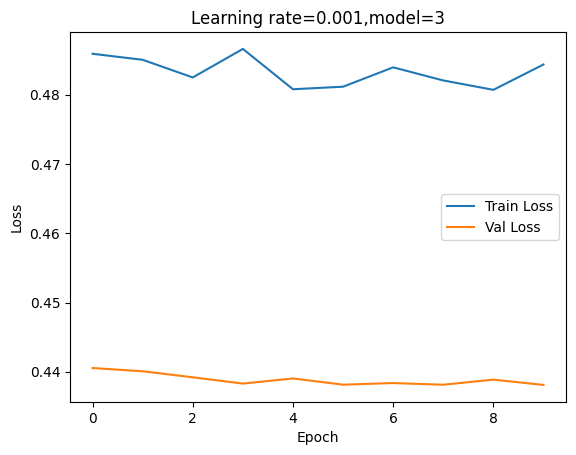

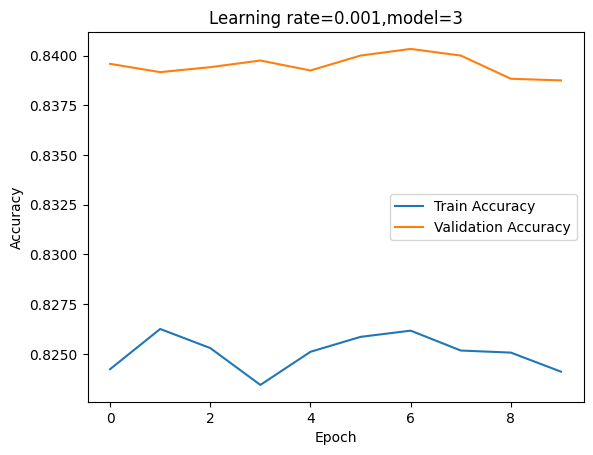

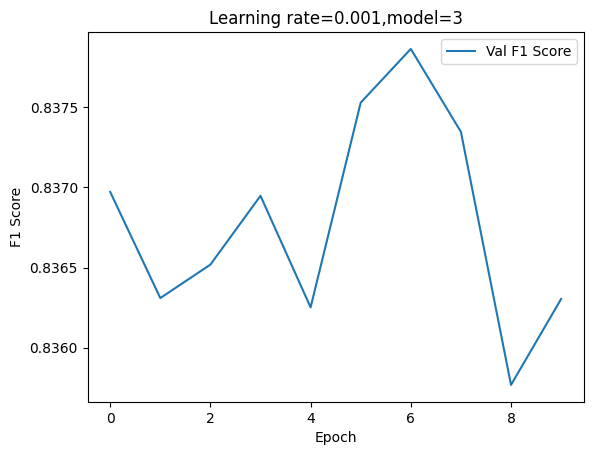

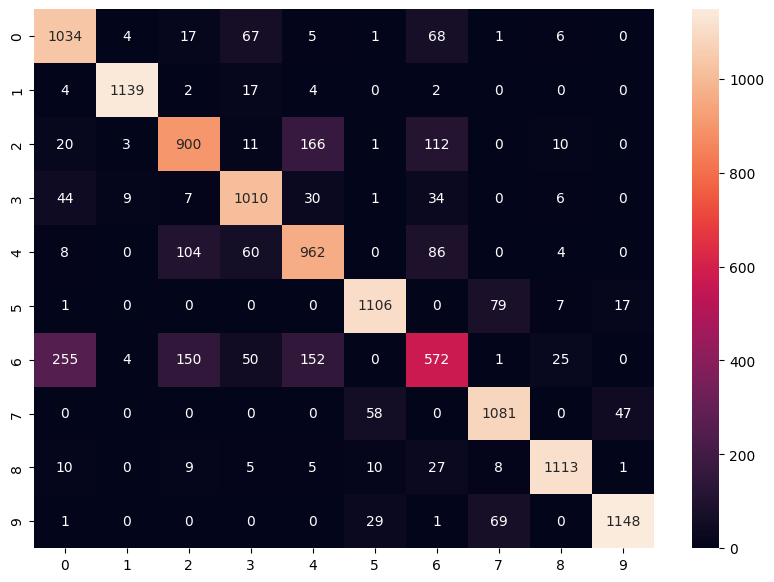

Accuracy: 83.88%
Loss: 0.43810372472468473
Average Specificity: 0.9820767832655392
Average Precision: 0.8365634014668855
Average Recall: 0.839709605225667
Average F1 Score: 0.8363040430387398


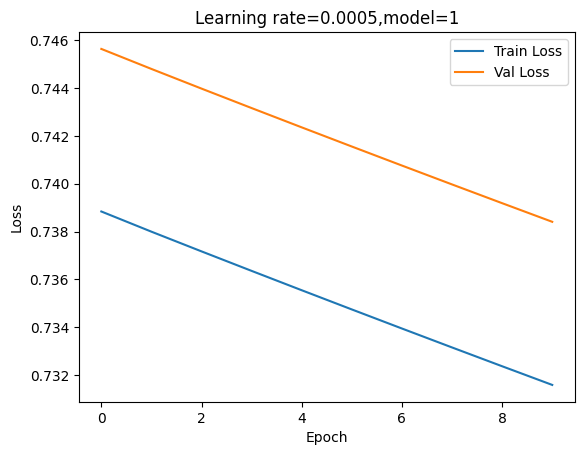

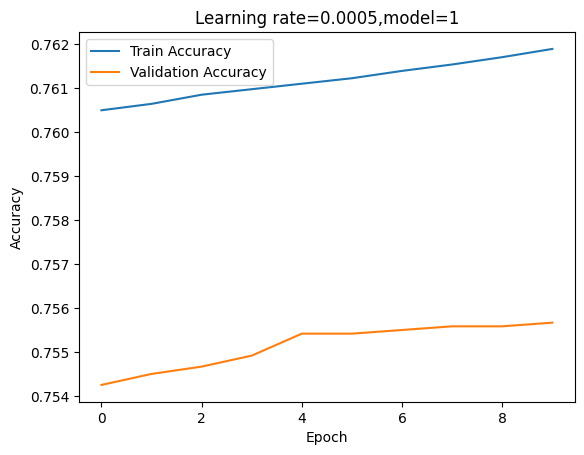

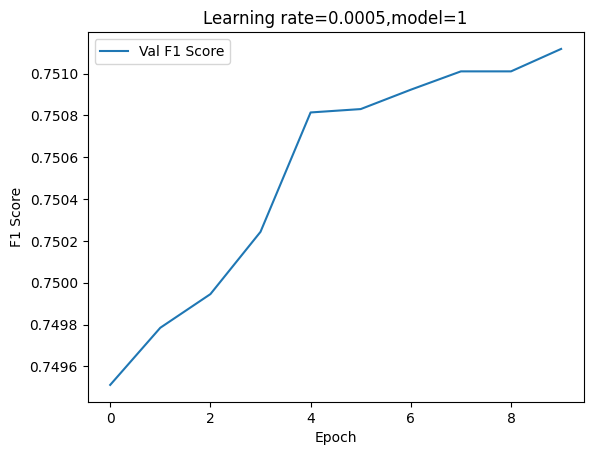

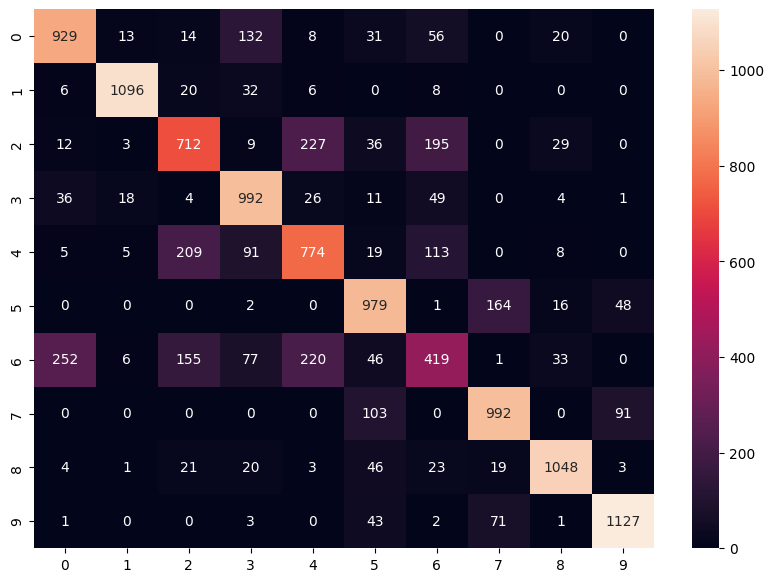

Accuracy: 75.57%
Loss: 0.7384091113889375
Average Specificity: 0.9728442060217576
Average Precision: 0.7492070655319812
Average Recall: 0.7571815989352825
Average F1 Score: 0.7511182566240665


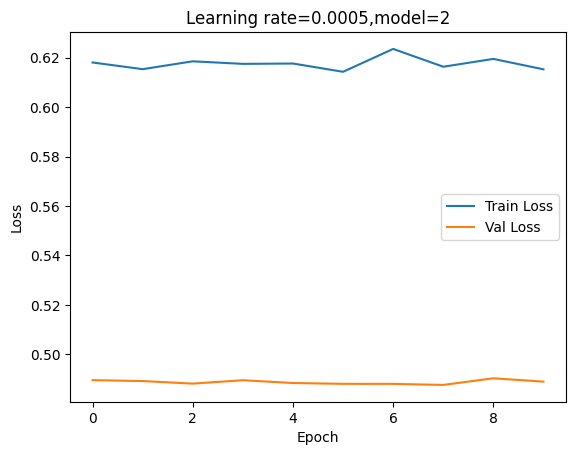

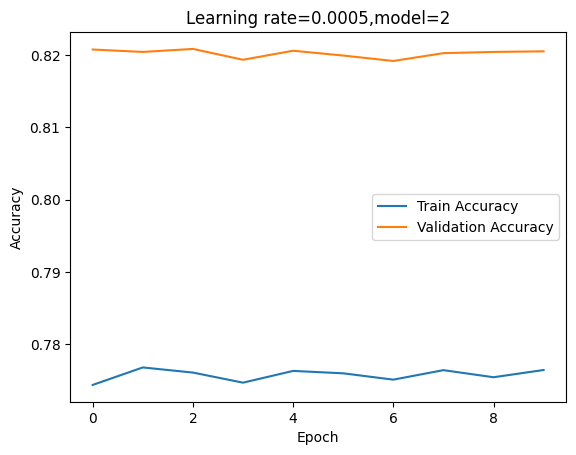

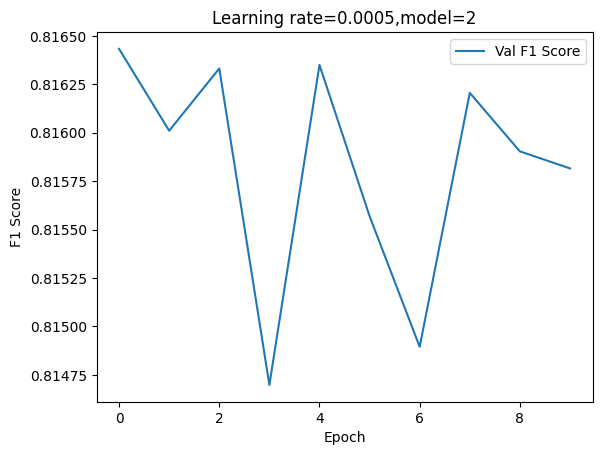

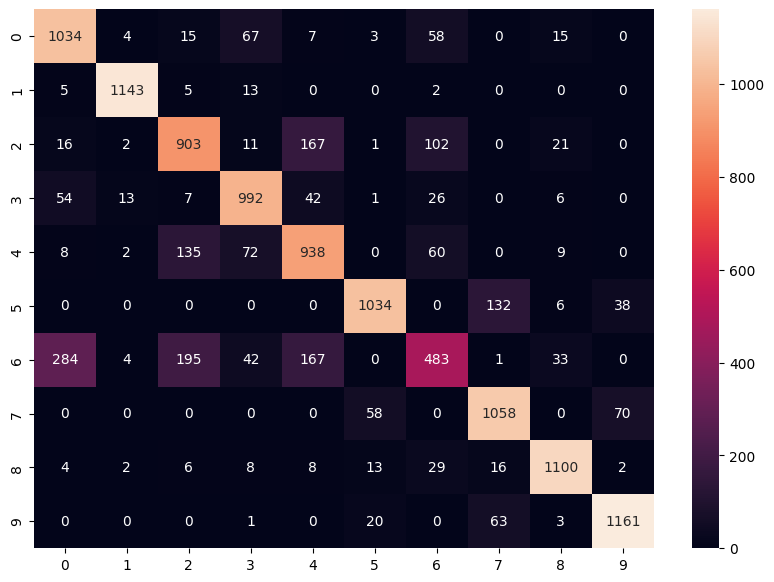

Accuracy: 82.05%
Loss: 0.48894398029689773
Average Specificity: 0.9800468563085364
Average Precision: 0.8173624673737944
Average Recall: 0.8214552514348222
Average F1 Score: 0.8158156861349823


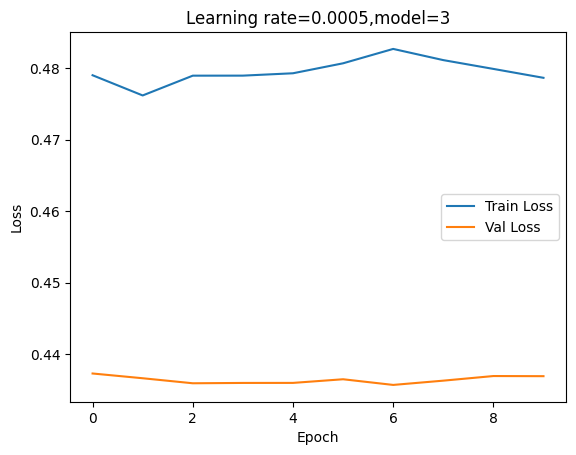

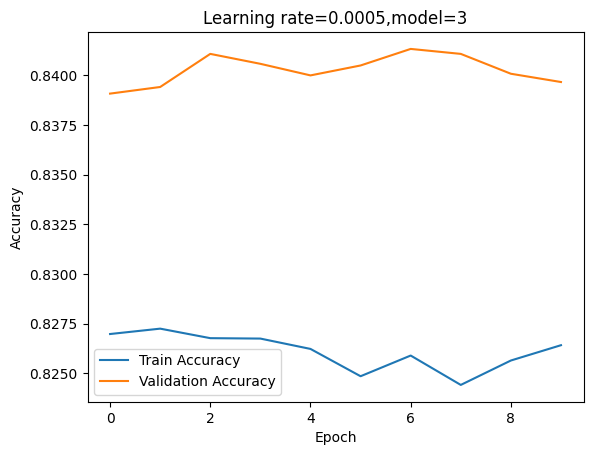

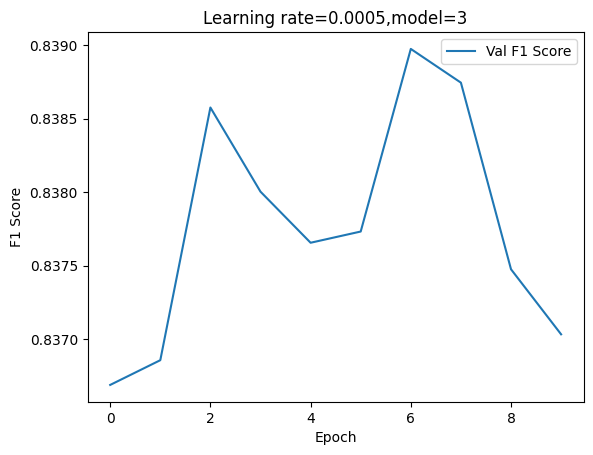

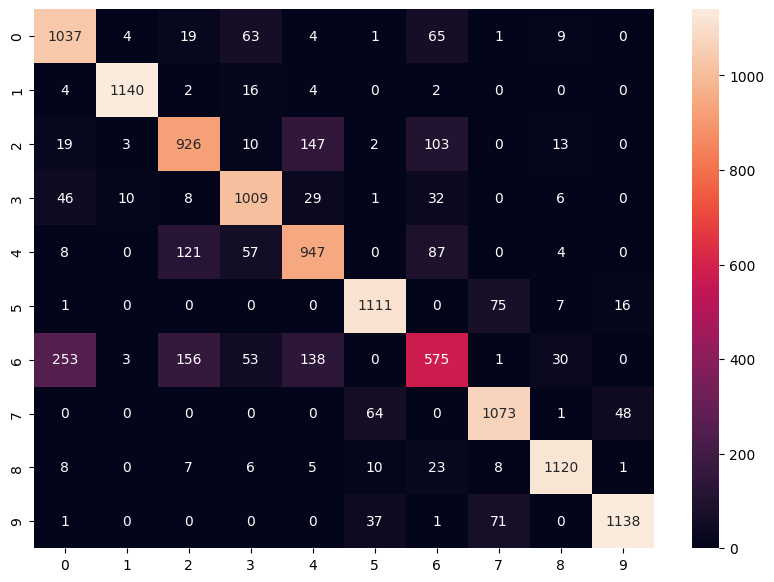

Accuracy: 83.97%
Loss: 0.43690648289999007
Average Specificity: 0.9821787407098928
Average Precision: 0.8371620757039627
Average Recall: 0.8406321548567236
Average F1 Score: 0.8370333141051713


In [15]:
networks = [
        NeuralNetwork([
            Dense(28 * 28, 256),
            ReLU(),
            Dense(256, 10),
            Softmax()
        ]),
        NeuralNetwork([
            Dense(28*28, 512),
            BatchNormalization(512),
            ReLU(),
            Dropout(0.2),
            Dense(512, 256),
            BatchNormalization(256),
            ReLU(),
            Dropout(0.2),
            Dense(256, 10),
            Softmax()
        ]),
        NeuralNetwork([
            Dense(28*28, 256),
            BatchNormalization(256),
            ReLU(),
            Dropout(0.2),
            Dense(256, 10),
            Softmax()
        ])
    ]
# The hyperparameter we'll change is the number of neurons in the hidden layer, ranging from n_neurons[0] to n_neurons[-1]
best_model=None
best_f1=0.0
learning_rates = [8e-3, 5e-3, 1e-3, 5e-4]
for learning_rate in learning_rates:
    for index, model in enumerate(networks):
        # Train
        model.train(X_train, y_train,X_val,y_val,10,64,learning_rate,index+1)

        current_accuracy,current_loss,current_f1 = model.evaluate(X_val, y_val)
        
        if current_f1>best_f1:
            best_f1=current_f1
            best_model=model

best_model.save_model(filepath)


Testing block

In [16]:
best_model.load_model(filepath)
best_model.evaluate(X_test,y_test)

Accuracy: 83.49%
Loss: 0.46122599493792116
Average Specificity: 0.9816555555555556
Average Precision: 0.8316024472016295
Average Recall: 0.8349
Average F1 Score: 0.8320719133440434


(0.8349, 0.46122599493792116, 0.8320719133440434)